In [1]:
import gym, importlib, sys, warnings, IPython
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%autosave 240
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.contrib.slim as slim
from scipy.signal import lfilter

Autosaving every 240 seconds

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.__version__

'1.13.1'

In [3]:
def discount(x, gamma=0.99): return lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

def maximize(optimizer, value, **kwargs): return optimizer.minimize(-value, **kwargs)

In [4]:
name="cp-stripped"
num_episodes = 100
n_epochs = 501 # 10001
max_buf = 1000

## Cartpole Setup

In [5]:
tf.reset_default_graph()
env = gym.make('CartPole-v0')
print(env.observation_space.shape[0], env.action_space)
env.observation_space.sample()

4 Discrete(2)


array([-1.8415875e+00,  2.8113519e+38, -8.1797257e-02, -9.3371685e+37],
      dtype=float32)

In [6]:
[env.action_space.sample() for _ in range(10)]

# st = env.reset()
# [act(sess.run(actor, feed_dict={states_St:[st]}).squeeze()) for _ in range(10)]

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1]

## Setup Stripped-down Policy Net

In [7]:
alpha=0.52
hseq0 = [int(h) for h in ["16"]*2]
wgts_init = tf.truncated_normal_initializer(stddev=0.01)
bias_init = tf.truncated_normal_initializer(mean=0.01, stddev=0.01)

def PolicyNet(state, 
              hSeq=hseq0, 
              gamma_reg=1e-1):
    '''Agent's Action Policy Network (example)
        This one is for a binary action space'''
    with tf.variable_scope("pnet"):
        regularizer = slim.l2_regularizer(gamma_reg)
        hidden = slim.fully_connected(
            slim.flatten(state),
            num_outputs=hSeq[0],
            activation_fn=tf.nn.relu,
            weights_regularizer=regularizer,
            weights_initializer=wgts_init,
            biases_initializer=bias_init
        )
        if (len(hSeq) > 1):
            hidden = slim.stack(hidden,
                                slim.fully_connected,
                                list(hSeq[1:]),
                                activation_fn=tf.nn.relu,
                                weights_regularizer=regularizer,
                                weights_initializer=wgts_init,
                                biases_initializer=bias_init
                                )
        apn = slim.fully_connected(
            hidden, 1,
            activation_fn=tf.nn.sigmoid,
            weights_initializer=wgts_init,
            biases_initializer=bias_init
        )
    return apn

states_St = tf.placeholder(shape=[None, env.observation_space.shape[0]], dtype=tf.float32, name='states')
returns_Gt = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='returns_discounted')
actions_At = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='actions-taken')

actor = PolicyNet(states_St)
act = lambda p: 1*(np.random.rand() < p)

lnPi_t = (actions_At) * tf.log(actor) + (1.-actions_At)*tf.log(1.-actor)
GlnPi_t = returns_Gt * lnPi_t
rfobj = alpha * tf.reduce_sum(GlnPi_t)
rfoptimizer = tf.train.AdamOptimizer(learning_rate=3e-3)
# rfoptimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-1)
rf_train = rfoptimizer.minimize(-1.*rfobj)
rf_grads = rfoptimizer.compute_gradients(loss=rfobj, 
                                         var_list=tf.trainable_variables(scope="pnet"))
gvs = rfoptimizer.compute_gradients(loss=rfobj, 
                                    var_list=tf.trainable_variables(scope="pnet"))

def train(sess, epbuf):
    buf = np.array(epbuf)
    states = np.squeeze(buf[:, 0])
    actions = np.squeeze(buf[:, 1])
    rewards = np.squeeze(buf[:, 2])
    next_states = np.squeeze(buf[:, 3])

    # generate discounted returns; goes into G_t
    discounted_returns = discount(np.hstack([rewards, [0.]]))
    discounted_returns = discounted_returns[:-1, None]
    feed_dict = {
        states_St: np.vstack(states),
        actions_At: np.vstack(actions),
        returns_Gt: np.vstack(discounted_returns)
    }
    # Generate network statistics to periodically save
    obj, LL, _ = sess.run(
        [rfobj, tf.reduce_mean(lnPi_t), rf_train],
        feed_dict=feed_dict
    )
    return obj, LL

def get_rollout(env, buf_lim=max_buf):
    buf = []
    last_total_return, d, s = 0, False, env.reset() 
    while (len(buf) < buf_lim) and not d:
        a_t = act(sess.run(actor, 
                   feed_dict={states_St:np.expand_dims(s.flatten(),axis=0)}).squeeze()) 
        s1, r, d, *rest = env.step(a_t)
        buf.append([s, a_t, float(r), s1])
        last_total_return += float(r)
        s = s1
    return buf, last_total_return

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.


### Training...

In [8]:
saver = tf.train.Saver(max_to_keep=1)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Baseline agent

In [9]:
print('Baselining untrained pnet...')
uplen0 = []
for k in range(num_episodes):
    episode_buffer, last_total_return = get_rollout(env)
    uplen0.append(last_total_return)
    if k%5 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf = np.mean(uplen0)
print("\nCartpole stays up for an average of {} steps".format(base_perf))

Baselining untrained pnet...
Episode 95/100
Cartpole stays up for an average of 21.74 steps


## Train

In [10]:
print("Starting agent " + str(name))
obs = []
with sess.as_default(), sess.graph.as_default():
    for tk in range(int(n_epochs)):
        episode_buffer, last_total_return = get_rollout(env)
        ob, ll = train(sess, episode_buffer)
        obs.append(ob)
        print("\rEpoch no.: {}/{} \tReward, Obj, mean LL: ({}, {}, {})".format(tk, n_epochs, len(episode_buffer), ob, ll), end="")

Starting agent cp-stripped
Epoch no.: 500/501 	Reward, Obj, mean LL: (195, -3066.010009765625, -0.5286259651184082)

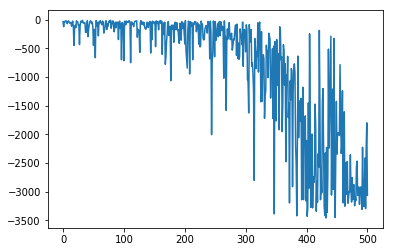

In [11]:
plt.plot(obs)

## Test & Evaluate

In [12]:
# Test pnet!
print('Testing...') 

uplen = []
for k in range(num_episodes):
    episode_buffer, last_total_return = get_rollout(env)
    uplen.append(last_total_return)
    if k%5 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf = np.mean(uplen)
print("\nCartpole stays up for an average of {} steps compared to baseline {} steps".format(trained_perf, base_perf) )

Testing...
Episode 95/100
Cartpole stays up for an average of 176.84 steps compared to baseline 21.74 steps


Text(0.5, 1.0, 'Trained Episode Lengths')

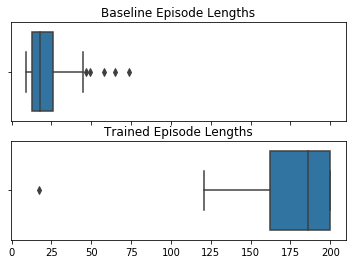

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.boxplot(uplen0, ax = axs[0])
axs[0].set_title('Baseline Episode Lengths')
sns.boxplot(uplen, ax = axs[1])
axs[1].set_title('Trained Episode Lengths')

In [14]:
buf = []
last_total_return, d, s = 0, False, env.reset() 
while (len(buf) < 1000) and not d:
    a_t = act(sess.run(actor, 
               feed_dict={states_St:np.expand_dims(s.flatten(),axis=0)}).squeeze()) 
    s1, r, d, *rest = env.step(a_t)
    env.render()
    buf.append([s, a_t, float(r), s1])
    last_total_return += float(r)
    s = s1
    print("\r\tEpisode Length", len(buf), end="")

	Episode Length 184

In [15]:
sess.close()